In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=300):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [4]:
## Resample training data
#resample_data(train_dir)
#resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3500 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model with L2 regularization
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers with L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)

# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 299, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 299, 224, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions
        

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'InceptionResNetV2.3.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Epoch 1/1000
126/126 [==============================] - 36s 275ms/step
Epoch 1 - Validation Loss: 4.0686, Validation Accuracy: 0.0813, Validation Precision: 0.0231

Epoch 1: val_loss improved from inf to 4.06863, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 290s - loss: 4.7947 - acc: 0.1820 - val_loss: 4.0686 - val_acc: 0.0813 - lr: 1.0000e-04 - 290s/epoch - 1s/step
Epoch 2/1000
126/126 [==============================] - 35s 278ms/step
Epoch 2 - Validation Loss: 3.1934, Validation Accuracy: 0.0778, Validation Precision: 0.5224

Epoch 2: val_loss improved from 4.06863 to 3.19341, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 262s - loss: 3.5475 - acc: 0.2400 - val_loss: 3.1934 - val_acc: 0.0778 - lr: 1.0000e-04 - 262s/epoch - 1s/step
Epoch 3/1000
126/126 [==============================] - 35s 275ms/step
Epoch 3 - Validation Loss: 2.7558, Validation Accuracy: 0.1307, Validation Precision: 0.0280

Epoch 3: val_loss improved from 3.19341 to 2.75583, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 262s - loss: 2.9496 - acc: 0.2823 - val_loss: 2.7558 - val_acc: 0.1307 - lr: 1.0000e-04 - 262s/epoch - 1s/step
Epoch 4/1000
126/126 [==============================] - 35s 274ms/step
Epoch 4 - Validation Loss: 2.5913, Validation Accuracy: 0.1172, Validation Precision: 0.0272

Epoch 4: val_loss improved from 2.75583 to 2.59129, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 2.6243 - acc: 0.2980 - val_loss: 2.5913 - val_acc: 0.1172 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 5/1000
126/126 [==============================] - 35s 275ms/step
Epoch 5 - Validation Loss: 2.3728, Validation Accuracy: 0.1392, Validation Precision: 0.0272

Epoch 5: val_loss improved from 2.59129 to 2.37280, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 2.4266 - acc: 0.3014 - val_loss: 2.3728 - val_acc: 0.1392 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 6/1000
126/126 [==============================] - 35s 275ms/step
Epoch 6 - Validation Loss: 2.2167, Validation Accuracy: 0.1466, Validation Precision: 0.0212

Epoch 6: val_loss improved from 2.37280 to 2.21671, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 2.2785 - acc: 0.3246 - val_loss: 2.2167 - val_acc: 0.1466 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 7/1000
126/126 [==============================] - 35s 275ms/step
Epoch 7 - Validation Loss: 2.1600, Validation Accuracy: 0.1576, Validation Precision: 0.0265

Epoch 7: val_loss improved from 2.21671 to 2.16003, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 2.1627 - acc: 0.3354 - val_loss: 2.1600 - val_acc: 0.1576 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 8/1000
126/126 [==============================] - 35s 276ms/step
Epoch 8 - Validation Loss: 2.1246, Validation Accuracy: 0.1516, Validation Precision: 0.0280

Epoch 8: val_loss improved from 2.16003 to 2.12460, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 2.1040 - acc: 0.3286 - val_loss: 2.1246 - val_acc: 0.1516 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 9/1000
126/126 [==============================] - 35s 275ms/step
Epoch 9 - Validation Loss: 2.0425, Validation Accuracy: 0.1671, Validation Precision: 0.0330

Epoch 9: val_loss improved from 2.12460 to 2.04246, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 2.0275 - acc: 0.3600 - val_loss: 2.0425 - val_acc: 0.1671 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 10/1000
126/126 [==============================] - 35s 275ms/step
Epoch 10 - Validation Loss: 2.0653, Validation Accuracy: 0.0938, Validation Precision: 0.0154

Epoch 10: val_loss did not improve from 2.04246
219/219 - 259s - loss: 1.9672 - acc: 0.3606 - val_loss: 2.0653 - val_acc: 0.0938 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 11 - Validation Loss: 1.9076, Validation Accuracy: 0.1496, Validation Precision: 0.4415

Epoch 11: val_loss improved from 2.04246 to 1.90764, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 1.9432 - acc: 0.3591 - val_loss: 1.9076 - val_acc: 0.1496 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 12/1000
126/126 [==============================] - 35s 275ms/step
Epoch 12 - Validation Loss: 1.9252, Validation Accuracy: 0.1631, Validation Precision: 0.4681

Epoch 12: val_loss did not improve from 1.90764
219/219 - 259s - loss: 1.8819 - acc: 0.3737 - val_loss: 1.9252 - val_acc: 0.1631 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 275ms/step
Epoch 13 - Validation Loss: 1.9651, Validation Accuracy: 0.1611, Validation Precision: 0.4368

Epoch 13: val_loss did not improve from 1.90764
219/219 - 259s - loss: 1.8628 - acc: 0.3689 - val_loss: 1.9651 - val_acc: 0.1611 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 14/1000
126/126 [==============================] - 35s 274ms/step
Epoch 14 - Validation Loss: 1.8721, Validation Accuracy: 0.1486, Validation Precision: 0.4062

Epoch 14: val_loss improved from 1.90764 to 1.87211, saving model to InceptionResNetV2.3.h5
219/219 - 260s - loss: 1.8448 - acc: 0.3711 - val_loss: 1.8721 - val_acc: 0.1486 - lr: 1.0000e-04 - 260s/epoch - 1s/step
Epoch 15/1000
126/126 [==============================] - 35s 275ms/step
Epoch 15 - Validation Loss: 1.8408, Validation Accuracy: 0.1631, Validation Precision: 0.5300

Epoch 15: val_loss improved from 1.87211 to 1.84082, saving model to InceptionResNetV2.3.h5
219/219 - 261s - loss: 1.8085 - acc: 0.

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 260s - loss: 1.7647 - acc: 0.4091 - val_loss: 1.8143 - val_acc: 0.1666 - lr: 1.0000e-04 - 260s/epoch - 1s/step
Epoch 17/1000
126/126 [==============================] - 35s 274ms/step
Epoch 17 - Validation Loss: 1.8100, Validation Accuracy: 0.1771, Validation Precision: 0.0222

Epoch 17: val_loss improved from 1.81434 to 1.80999, saving model to InceptionResNetV2.3.h5
219/219 - 261s - loss: 1.7448 - acc: 0.4206 - val_loss: 1.8100 - val_acc: 0.1771 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 18/1000
126/126 [==============================] - 35s 276ms/step
Epoch 18 - Validation Loss: 1.9692, Validation Accuracy: 0.1387, Validation Precision: 0.6996

Epoch 18: val_loss did not improve from 1.80999
219/219 - 259s - loss: 1.7309 - acc: 0.4129 - val_loss: 1.9692 - val_acc: 0.1387 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 19/1000
126/126 [==============================] - 35s 275ms/step
Epoch 19 - Validation Loss: 1.8194, Validation Accuracy: 0.1666, Validation Precision: 0.70

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 20 - Validation Loss: 1.7778, Validation Accuracy: 0.1631, Validation Precision: 0.6960

Epoch 20: val_loss improved from 1.80999 to 1.77779, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 1.6921 - acc: 0.4189 - val_loss: 1.7778 - val_acc: 0.1631 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 21/1000
126/126 [==============================] - 35s 275ms/step
Epoch 21 - Validation Loss: 1.7518, Validation Accuracy: 0.1441, Validation Precision: 0.6963

Epoch 21: val_loss improved from 1.77779 to 1.75179, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 1.6700 - acc: 0.4283 - val_loss: 1.7518 - val_acc: 0.1441 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 22/1000
126/126 [==============================] - 35s 275ms/step
Epoch 22 - Validation Loss: 1.7763, Validation Accuracy: 0.1751, Validation Precision: 0.6865

Epoch 22: val_loss did not improve from 1.75179
219/219 - 259s - loss: 1.6636 - acc: 0.4203 - val_loss: 1.7763 - val_acc: 0.1751 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 23/1000
126/126 [==============================] - 35s 276ms/step
Epoch 23 - Validation Loss: 1.7541, Validation Accuracy: 0.1696, Validation Precision: 0.0253

Epoch 23: val_loss did not improve from 1.75179
219/219 - 259s - loss: 1.6618 - acc: 0.4183 - val_loss: 1.7541 - val_acc: 0.1696 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 24/1000
126/126 [==============================] - 35s 274ms/step
Epoch 24 - Validation Loss: 1.7561, Validation Accuracy: 0.1716, Validation Precision: 0.4747

Epoch 24: val_loss did not improve from 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 260s - loss: 1.6381 - acc: 0.4151 - val_loss: 1.7343 - val_acc: 0.1691 - lr: 1.0000e-04 - 260s/epoch - 1s/step
Epoch 26/1000
126/126 [==============================] - 35s 274ms/step
Epoch 26 - Validation Loss: 1.7498, Validation Accuracy: 0.1706, Validation Precision: 0.0301

Epoch 26: val_loss did not improve from 1.73425
219/219 - 259s - loss: 1.6135 - acc: 0.4289 - val_loss: 1.7498 - val_acc: 0.1706 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 27 - Validation Loss: 1.7361, Validation Accuracy: 0.1686, Validation Precision: 0.0289

Epoch 27: val_loss did not improve from 1.73425
219/219 - 259s - loss: 1.6100 - acc: 0.4274 - val_loss: 1.7361 - val_acc: 0.1686 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 28 - Validation Loss: 1.7453, Validation Accuracy: 0.1691, Validation Precision: 0.0285

Epoch 28: val_loss did not improve from 1.73425
219/219 - 259s - loss: 1.6062 - acc: 0.4269 - val_loss: 1.7453 - val_acc: 0.1691 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 277ms/step
Epoch 29 - Validation Loss: 1.7004, Validation Accuracy: 0.1791, Validation Precision: 0.0296

Epoch 29: val_loss improved from 1.73425 to 1.70040, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 1.5930 - acc: 0.4251 - val_loss: 1.7004 - val_acc: 0.1791 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 30/1000
126/126 [==============================] - 35s 275ms/step
Epoch 30 - Validation Loss: 1.7107, Validation Accuracy: 0.1855, Validation Precision: 0.0251

Epoch 30: val_loss did not improve from 1.70040
219/219 - 259s - loss: 1.5776 - acc: 0.4366 - val_loss: 1.7107 - val_acc: 0.1855 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 31 - Validation Loss: 1.7187, Validation Accuracy: 0.1706, Validation Precision: 0.0248

Epoch 31: val_loss did not improve from 1.70040
219/219 - 259s - loss: 1.5645 - acc: 0.4406 - val_loss: 1.7187 - val_acc: 0.1706 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 32 - Validation Loss: 1.6919, Validation Accuracy: 0.1686, Validation Precision: 0.0246

Epoch 32: val_loss improved from 1.70040 to 1.69185, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 1.5522 - acc: 0.4431 - val_loss: 1.6919 - val_acc: 0.1686 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 33/1000
126/126 [==============================] - 35s 274ms/step
Epoch 33 - Validation Loss: 1.6939, Validation Accuracy: 0.1761, Validation Precision: 0.0383

Epoch 33: val_loss did not improve from 1.69185
219/219 - 259s - loss: 1.5454 - acc: 0.4500 - val_loss: 1.6939 - val_acc: 0.1761 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 34/1000
126/126 [==============================] - 35s 274ms/step
Epoch 34 - Validation Loss: 1.6928, Validation Accuracy: 0.1845, Validation Precision: 0.0320

Epoch 34: val_loss did not improve from 1.69185
219/219 - 259s - loss: 1.5291 - acc: 0.4506 - val_loss: 1.6928 - val_acc: 0.1845 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 277ms/step
Epoch 35 - Validation Loss: 1.7055, Validation Accuracy: 0.2175, Validation Precision: 0.0304

Epoch 35: val_loss did not improve from 1.69185
219/219 - 259s - loss: 1.5180 - acc: 0.4643 - val_loss: 1.7055 - val_acc: 0.2175 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 36 - Validation Loss: 1.6906, Validation Accuracy: 0.2135, Validation Precision: 0.0273

Epoch 36: val_loss improved from 1.69185 to 1.69060, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 1.5261 - acc: 0.4540 - val_loss: 1.6906 - val_acc: 0.2135 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 37/1000
126/126 [==============================] - 35s 274ms/step
Epoch 37 - Validation Loss: 1.6765, Validation Accuracy: 0.2090, Validation Precision: 0.5239

Epoch 37: val_loss improved from 1.69060 to 1.67648, saving model to InceptionResNetV2.3.h5
219/219 - 261s - loss: 1.5268 - acc: 0.4471 - val_loss: 1.6765 - val_acc: 0.2090 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 38/1000
126/126 [==============================] - 35s 274ms/step
Epoch 38 - Validation Loss: 1.6958, Validation Accuracy: 0.2035, Validation Precision: 0.0231

Epoch 38: val_loss did not improve from 1.67648
219/219 - 259s - loss: 1.5068 - acc: 0.4594 - val_loss: 1.6958 - val_acc: 0.2035 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 277ms/step
Epoch 39 - Validation Loss: 1.6805, Validation Accuracy: 0.2200, Validation Precision: 0.0300

Epoch 39: val_loss did not improve from 1.67648
219/219 - 259s - loss: 1.4928 - acc: 0.4606 - val_loss: 1.6805 - val_acc: 0.2200 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 277ms/step
Epoch 40 - Validation Loss: 1.6694, Validation Accuracy: 0.1950, Validation Precision: 0.6927

Epoch 40: val_loss improved from 1.67648 to 1.66942, saving model to InceptionResNetV2.3.h5
219/219 - 261s - loss: 1.4769 - acc: 0.4729 - val_loss: 1.6694 - val_acc: 0.1950 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 41/1000
126/126 [==============================] - 35s 275ms/step
Epoch 41 - Validation Loss: 1.6482, Validation Accuracy: 0.2224, Validation Precision: 0.6975

Epoch 41: val_loss improved from 1.66942 to 1.64821, saving model to InceptionResNetV2.3.h5
219/219 - 261s - loss: 1.4775 - acc: 0.4637 - val_loss: 1.6482 - val_acc: 0.2224 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 42/1000
126/126 [==============================] - 35s 274ms/step
Epoch 42 - Validation Loss: 1.6725, Validation Accuracy: 0.2105, Validation Precision: 0.4951

Epoch 42: val_loss did not improve from 1.64821
219/219 - 259s - loss: 1.4722 - acc: 0.

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 69 - Validation Loss: 1.5341, Validation Accuracy: 0.2384, Validation Precision: 0.0251

Epoch 69: val_loss improved from 1.54239 to 1.53409, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 1.2844 - acc: 0.5106 - val_loss: 1.5341 - val_acc: 0.2384 - lr: 1.0000e-04 - 261s/epoch - 1s/step
Epoch 70/1000
126/126 [==============================] - 35s 273ms/step
Epoch 70 - Validation Loss: 1.5428, Validation Accuracy: 0.2249, Validation Precision: 0.0272

Epoch 70: val_loss did not improve from 1.53409
219/219 - 259s - loss: 1.3010 - acc: 0.5100 - val_loss: 1.5428 - val_acc: 0.2249 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 71/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 71 - Validation Loss: 1.5374, Validation Accuracy: 0.2309, Validation Precision: 0.0255

Epoch 71: val_loss did not improve from 1.53409
219/219 - 257s - loss: 1.2881 - acc: 0.5054 - val_loss: 1.5374 - val_acc: 0.2309 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 72/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 273ms/step
Epoch 72 - Validation Loss: 1.4952, Validation Accuracy: 0.2424, Validation Precision: 0.0282

Epoch 72: val_loss improved from 1.53409 to 1.49517, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 259s - loss: 1.2647 - acc: 0.5106 - val_loss: 1.4952 - val_acc: 0.2424 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 73/1000
126/126 [==============================] - 34s 273ms/step
Epoch 73 - Validation Loss: 1.5627, Validation Accuracy: 0.2279, Validation Precision: 0.0326

Epoch 73: val_loss did not improve from 1.49517
219/219 - 257s - loss: 1.2732 - acc: 0.5131 - val_loss: 1.5627 - val_acc: 0.2279 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 74/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 74 - Validation Loss: 1.5489, Validation Accuracy: 0.2249, Validation Precision: 0.0277

Epoch 74: val_loss did not improve from 1.49517
219/219 - 257s - loss: 1.2447 - acc: 0.5209 - val_loss: 1.5489 - val_acc: 0.2249 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 274ms/step
Epoch 75 - Validation Loss: 1.5129, Validation Accuracy: 0.2364, Validation Precision: 0.0282

Epoch 75: val_loss did not improve from 1.49517
219/219 - 257s - loss: 1.2640 - acc: 0.5074 - val_loss: 1.5129 - val_acc: 0.2364 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 76/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 273ms/step
Epoch 76 - Validation Loss: 1.5300, Validation Accuracy: 0.2304, Validation Precision: 0.0257

Epoch 76: val_loss did not improve from 1.49517
219/219 - 257s - loss: 1.2616 - acc: 0.5089 - val_loss: 1.5300 - val_acc: 0.2304 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 77 - Validation Loss: 1.5654, Validation Accuracy: 0.2294, Validation Precision: 0.0303

Epoch 77: val_loss did not improve from 1.49517
219/219 - 257s - loss: 1.2406 - acc: 0.5320 - val_loss: 1.5654 - val_acc: 0.2294 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 78/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 274ms/step
Epoch 78 - Validation Loss: 1.4969, Validation Accuracy: 0.2349, Validation Precision: 0.0289

Epoch 78: val_loss did not improve from 1.49517
219/219 - 257s - loss: 1.2271 - acc: 0.5240 - val_loss: 1.4969 - val_acc: 0.2349 - lr: 5.0000e-05 - 257s/epoch - 1s/step
Epoch 79/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 79 - Validation Loss: 1.5723, Validation Accuracy: 0.2239, Validation Precision: 0.0299

Epoch 79: val_loss did not improve from 1.49517
219/219 - 257s - loss: 1.2141 - acc: 0.5240 - val_loss: 1.5723 - val_acc: 0.2239 - lr: 5.0000e-05 - 257s/epoch - 1s/step
Epoch 80/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 273ms/step
Epoch 80 - Validation Loss: 1.5423, Validation Accuracy: 0.2324, Validation Precision: 0.0231

Epoch 80: val_loss did not improve from 1.49517
219/219 - 257s - loss: 1.2073 - acc: 0.5383 - val_loss: 1.5423 - val_acc: 0.2324 - lr: 5.0000e-05 - 257s/epoch - 1s/step
Epoch 81/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 81 - Validation Loss: 1.5033, Validation Accuracy: 0.2519, Validation Precision: 0.0274

Epoch 81: val_loss did not improve from 1.49517
219/219 - 257s - loss: 1.2004 - acc: 0.5271 - val_loss: 1.5033 - val_acc: 0.2519 - lr: 5.0000e-05 - 257s/epoch - 1s/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 273ms/step
Epoch 82 - Validation Loss: 1.4876, Validation Accuracy: 0.2404, Validation Precision: 0.0282

Epoch 82: val_loss improved from 1.49517 to 1.48759, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 259s - loss: 1.2101 - acc: 0.5274 - val_loss: 1.4876 - val_acc: 0.2404 - lr: 5.0000e-05 - 259s/epoch - 1s/step
Epoch 83/1000
126/126 [==============================] - 35s 276ms/step
Epoch 83 - Validation Loss: 1.4836, Validation Accuracy: 0.2459, Validation Precision: 0.0273

Epoch 83: val_loss improved from 1.48759 to 1.48358, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 260s - loss: 1.1828 - acc: 0.5406 - val_loss: 1.4836 - val_acc: 0.2459 - lr: 5.0000e-05 - 260s/epoch - 1s/step
Epoch 84/1000
126/126 [==============================] - 35s 276ms/step
Epoch 84 - Validation Loss: 1.5180, Validation Accuracy: 0.2414, Validation Precision: 0.0279

Epoch 84: val_loss did not improve from 1.48358
219/219 - 259s - loss: 1.1986 - acc: 0.5289 - val_loss: 1.5180 - val_acc: 0.2414 - lr: 5.0000e-05 - 259s/epoch - 1s/step
Epoch 85/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 274ms/step
Epoch 85 - Validation Loss: 1.5699, Validation Accuracy: 0.2234, Validation Precision: 0.0279

Epoch 85: val_loss did not improve from 1.48358
219/219 - 258s - loss: 1.1755 - acc: 0.5489 - val_loss: 1.5699 - val_acc: 0.2234 - lr: 5.0000e-05 - 258s/epoch - 1s/step
Epoch 86/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 275ms/step
Epoch 86 - Validation Loss: 1.4777, Validation Accuracy: 0.2474, Validation Precision: 0.0295

Epoch 86: val_loss improved from 1.48358 to 1.47772, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 260s - loss: 1.1845 - acc: 0.5389 - val_loss: 1.4777 - val_acc: 0.2474 - lr: 5.0000e-05 - 260s/epoch - 1s/step
Epoch 87/1000
126/126 [==============================] - 34s 275ms/step
Epoch 87 - Validation Loss: 1.4807, Validation Accuracy: 0.2474, Validation Precision: 0.0258

Epoch 87: val_loss did not improve from 1.47772
219/219 - 257s - loss: 1.1618 - acc: 0.5477 - val_loss: 1.4807 - val_acc: 0.2474 - lr: 5.0000e-05 - 257s/epoch - 1s/step
Epoch 88/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 277ms/step
Epoch 88 - Validation Loss: 1.4849, Validation Accuracy: 0.2479, Validation Precision: 0.0288

Epoch 88: val_loss did not improve from 1.47772
219/219 - 262s - loss: 1.1650 - acc: 0.5420 - val_loss: 1.4849 - val_acc: 0.2479 - lr: 5.0000e-05 - 262s/epoch - 1s/step
Epoch 89/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 280ms/step
Epoch 89 - Validation Loss: 1.4883, Validation Accuracy: 0.2449, Validation Precision: 0.0319

Epoch 89: val_loss did not improve from 1.47772
219/219 - 265s - loss: 1.1574 - acc: 0.5529 - val_loss: 1.4883 - val_acc: 0.2449 - lr: 5.0000e-05 - 265s/epoch - 1s/step
Epoch 90/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 278ms/step
Epoch 90 - Validation Loss: 1.4945, Validation Accuracy: 0.2549, Validation Precision: 0.0265

Epoch 90: val_loss did not improve from 1.47772
219/219 - 264s - loss: 1.1558 - acc: 0.5514 - val_loss: 1.4945 - val_acc: 0.2549 - lr: 5.0000e-05 - 264s/epoch - 1s/step
Epoch 91/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 282ms/step
Epoch 91 - Validation Loss: 1.4797, Validation Accuracy: 0.2594, Validation Precision: 0.0274

Epoch 91: val_loss did not improve from 1.47772
219/219 - 268s - loss: 1.1691 - acc: 0.5403 - val_loss: 1.4797 - val_acc: 0.2594 - lr: 5.0000e-05 - 268s/epoch - 1s/step
Epoch 92/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 278ms/step
Epoch 92 - Validation Loss: 1.5134, Validation Accuracy: 0.2444, Validation Precision: 0.0271

Epoch 92: val_loss did not improve from 1.47772
219/219 - 261s - loss: 1.1243 - acc: 0.5711 - val_loss: 1.5134 - val_acc: 0.2444 - lr: 2.5000e-05 - 261s/epoch - 1s/step
Epoch 93/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 93 - Validation Loss: 1.4814, Validation Accuracy: 0.2524, Validation Precision: 0.0279

Epoch 93: val_loss did not improve from 1.47772
219/219 - 259s - loss: 1.1434 - acc: 0.5674 - val_loss: 1.4814 - val_acc: 0.2524 - lr: 2.5000e-05 - 259s/epoch - 1s/step
Epoch 94/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 275ms/step
Epoch 94 - Validation Loss: 1.4755, Validation Accuracy: 0.2499, Validation Precision: 0.0269

Epoch 94: val_loss improved from 1.47772 to 1.47546, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 261s - loss: 1.1621 - acc: 0.5434 - val_loss: 1.4755 - val_acc: 0.2499 - lr: 2.5000e-05 - 261s/epoch - 1s/step
Epoch 95/1000
126/126 [==============================] - 35s 275ms/step
Epoch 95 - Validation Loss: 1.4485, Validation Accuracy: 0.2489, Validation Precision: 0.0269

Epoch 95: val_loss improved from 1.47546 to 1.44851, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 263s - loss: 1.1110 - acc: 0.5714 - val_loss: 1.4485 - val_acc: 0.2489 - lr: 2.5000e-05 - 263s/epoch - 1s/step
Epoch 96/1000
126/126 [==============================] - 35s 277ms/step
Epoch 96 - Validation Loss: 1.4672, Validation Accuracy: 0.2489, Validation Precision: 0.0288

Epoch 96: val_loss did not improve from 1.44851
219/219 - 259s - loss: 1.1278 - acc: 0.5583 - val_loss: 1.4672 - val_acc: 0.2489 - lr: 2.5000e-05 - 259s/epoch - 1s/step
Epoch 97/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 97 - Validation Loss: 1.5021, Validation Accuracy: 0.2464, Validation Precision: 0.0309

Epoch 97: val_loss did not improve from 1.44851
219/219 - 258s - loss: 1.1424 - acc: 0.5509 - val_loss: 1.5021 - val_acc: 0.2464 - lr: 2.5000e-05 - 258s/epoch - 1s/step
Epoch 98/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 275ms/step
Epoch 98 - Validation Loss: 1.4692, Validation Accuracy: 0.2514, Validation Precision: 0.0238

Epoch 98: val_loss did not improve from 1.44851
219/219 - 258s - loss: 1.1229 - acc: 0.5663 - val_loss: 1.4692 - val_acc: 0.2514 - lr: 2.5000e-05 - 258s/epoch - 1s/step
Epoch 99/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 284ms/step
Epoch 99 - Validation Loss: 1.4826, Validation Accuracy: 0.2464, Validation Precision: 0.0289

Epoch 99: val_loss did not improve from 1.44851
219/219 - 263s - loss: 1.1308 - acc: 0.5554 - val_loss: 1.4826 - val_acc: 0.2464 - lr: 2.5000e-05 - 263s/epoch - 1s/step
Epoch 100/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 282ms/step
Epoch 100 - Validation Loss: 1.4584, Validation Accuracy: 0.2509, Validation Precision: 0.0255

Epoch 100: val_loss did not improve from 1.44851
219/219 - 265s - loss: 1.1306 - acc: 0.5580 - val_loss: 1.4584 - val_acc: 0.2509 - lr: 2.5000e-05 - 265s/epoch - 1s/step
Epoch 101/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 101 - Validation Loss: 1.4366, Validation Accuracy: 0.2628, Validation Precision: 0.0321

Epoch 101: val_loss improved from 1.44851 to 1.43662, saving model to InceptionResNetV2.3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 263s - loss: 1.1243 - acc: 0.5714 - val_loss: 1.4366 - val_acc: 0.2628 - lr: 1.2500e-05 - 263s/epoch - 1s/step
Epoch 102/1000
126/126 [==============================] - 35s 278ms/step
Epoch 102 - Validation Loss: 1.4562, Validation Accuracy: 0.2589, Validation Precision: 0.0267

Epoch 102: val_loss did not improve from 1.43662
219/219 - 261s - loss: 1.1102 - acc: 0.5769 - val_loss: 1.4562 - val_acc: 0.2589 - lr: 1.2500e-05 - 261s/epoch - 1s/step
Epoch 103/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 277ms/step
Epoch 103 - Validation Loss: 1.4705, Validation Accuracy: 0.2474, Validation Precision: 0.0243

Epoch 103: val_loss did not improve from 1.43662
219/219 - 262s - loss: 1.1056 - acc: 0.5786 - val_loss: 1.4705 - val_acc: 0.2474 - lr: 1.2500e-05 - 262s/epoch - 1s/step
Epoch 104/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 278ms/step
Epoch 104 - Validation Loss: 1.4522, Validation Accuracy: 0.2584, Validation Precision: 0.0294

Epoch 104: val_loss did not improve from 1.43662
219/219 - 261s - loss: 1.1141 - acc: 0.5740 - val_loss: 1.4522 - val_acc: 0.2584 - lr: 1.2500e-05 - 261s/epoch - 1s/step
Epoch 105/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 105 - Validation Loss: 1.4430, Validation Accuracy: 0.2564, Validation Precision: 0.0361

Epoch 105: val_loss did not improve from 1.43662
219/219 - 263s - loss: 1.1084 - acc: 0.5789 - val_loss: 1.4430 - val_acc: 0.2564 - lr: 1.2500e-05 - 263s/epoch - 1s/step
Epoch 106/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 280ms/step
Epoch 106 - Validation Loss: 1.4507, Validation Accuracy: 0.2549, Validation Precision: 0.0224

Epoch 106: val_loss did not improve from 1.43662
219/219 - 263s - loss: 1.1112 - acc: 0.5629 - val_loss: 1.4507 - val_acc: 0.2549 - lr: 1.2500e-05 - 263s/epoch - 1s/step
Epoch 107/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 282ms/step
Epoch 107 - Validation Loss: 1.4632, Validation Accuracy: 0.2559, Validation Precision: 0.0259

Epoch 107: val_loss did not improve from 1.43662
219/219 - 270s - loss: 1.1122 - acc: 0.5614 - val_loss: 1.4632 - val_acc: 0.2559 - lr: 6.2500e-06 - 270s/epoch - 1s/step
Epoch 108/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 282ms/step
Epoch 108 - Validation Loss: 1.4542, Validation Accuracy: 0.2608, Validation Precision: 0.0311

Epoch 108: val_loss did not improve from 1.43662
219/219 - 270s - loss: 1.1150 - acc: 0.5697 - val_loss: 1.4542 - val_acc: 0.2608 - lr: 6.2500e-06 - 270s/epoch - 1s/step
Epoch 109/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 281ms/step
Epoch 109 - Validation Loss: 1.4462, Validation Accuracy: 0.2594, Validation Precision: 0.0247

Epoch 109: val_loss did not improve from 1.43662
219/219 - 266s - loss: 1.1159 - acc: 0.5674 - val_loss: 1.4462 - val_acc: 0.2594 - lr: 6.2500e-06 - 266s/epoch - 1s/step
Epoch 110/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 37s 289ms/step
Epoch 110 - Validation Loss: 1.4437, Validation Accuracy: 0.2623, Validation Precision: 0.0271

Epoch 110: val_loss did not improve from 1.43662
219/219 - 267s - loss: 1.1035 - acc: 0.5717 - val_loss: 1.4437 - val_acc: 0.2623 - lr: 6.2500e-06 - 267s/epoch - 1s/step
Epoch 111/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 281ms/step
Epoch 111 - Validation Loss: 1.4580, Validation Accuracy: 0.2574, Validation Precision: 0.0304

Epoch 111: val_loss did not improve from 1.43662
219/219 - 265s - loss: 1.1029 - acc: 0.5797 - val_loss: 1.4580 - val_acc: 0.2574 - lr: 6.2500e-06 - 265s/epoch - 1s/step
Epoch 112/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 281ms/step
Epoch 112 - Validation Loss: 1.4451, Validation Accuracy: 0.2599, Validation Precision: 0.0233

Epoch 112: val_loss did not improve from 1.43662
219/219 - 263s - loss: 1.1074 - acc: 0.5771 - val_loss: 1.4451 - val_acc: 0.2599 - lr: 3.1250e-06 - 263s/epoch - 1s/step
Epoch 113/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 279ms/step
Epoch 113 - Validation Loss: 1.4403, Validation Accuracy: 0.2584, Validation Precision: 0.0280

Epoch 113: val_loss did not improve from 1.43662
219/219 - 263s - loss: 1.0881 - acc: 0.5903 - val_loss: 1.4403 - val_acc: 0.2584 - lr: 3.1250e-06 - 263s/epoch - 1s/step
Epoch 114/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 278ms/step
Epoch 114 - Validation Loss: 1.4421, Validation Accuracy: 0.2594, Validation Precision: 0.0276

Epoch 114: val_loss did not improve from 1.43662
219/219 - 263s - loss: 1.1090 - acc: 0.5717 - val_loss: 1.4421 - val_acc: 0.2594 - lr: 3.1250e-06 - 263s/epoch - 1s/step
Epoch 115/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 279ms/step
Epoch 115 - Validation Loss: 1.4488, Validation Accuracy: 0.2584, Validation Precision: 0.0279

Epoch 115: val_loss did not improve from 1.43662
219/219 - 262s - loss: 1.0975 - acc: 0.5860 - val_loss: 1.4488 - val_acc: 0.2584 - lr: 3.1250e-06 - 262s/epoch - 1s/step
Epoch 116/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 279ms/step
Epoch 116 - Validation Loss: 1.4452, Validation Accuracy: 0.2603, Validation Precision: 0.0290

Epoch 116: val_loss did not improve from 1.43662
219/219 - 263s - loss: 1.1057 - acc: 0.5746 - val_loss: 1.4452 - val_acc: 0.2603 - lr: 3.1250e-06 - 263s/epoch - 1s/step
Epoch 117/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 279ms/step
Epoch 117 - Validation Loss: 1.4434, Validation Accuracy: 0.2608, Validation Precision: 0.0296

Epoch 117: val_loss did not improve from 1.43662
219/219 - 263s - loss: 1.0995 - acc: 0.5760 - val_loss: 1.4434 - val_acc: 0.2608 - lr: 1.5625e-06 - 263s/epoch - 1s/step
Epoch 118/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 36s 283ms/step
Epoch 118 - Validation Loss: 1.4441, Validation Accuracy: 0.2594, Validation Precision: 0.0229

Epoch 118: val_loss did not improve from 1.43662
219/219 - 264s - loss: 1.0956 - acc: 0.5809 - val_loss: 1.4441 - val_acc: 0.2594 - lr: 1.5625e-06 - 264s/epoch - 1s/step
Epoch 119/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 274ms/step
Epoch 119 - Validation Loss: 1.4496, Validation Accuracy: 0.2618, Validation Precision: 0.0306

Epoch 119: val_loss did not improve from 1.43662
219/219 - 262s - loss: 1.1084 - acc: 0.5777 - val_loss: 1.4496 - val_acc: 0.2618 - lr: 1.5625e-06 - 262s/epoch - 1s/step
Epoch 120/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 274ms/step
Epoch 120 - Validation Loss: 1.4452, Validation Accuracy: 0.2618, Validation Precision: 0.0284

Epoch 120: val_loss did not improve from 1.43662
219/219 - 258s - loss: 1.1044 - acc: 0.5769 - val_loss: 1.4452 - val_acc: 0.2618 - lr: 1.5625e-06 - 258s/epoch - 1s/step
Epoch 121/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 275ms/step
Epoch 121 - Validation Loss: 1.4417, Validation Accuracy: 0.2623, Validation Precision: 0.0269

Epoch 121: val_loss did not improve from 1.43662
219/219 - 258s - loss: 1.0921 - acc: 0.5823 - val_loss: 1.4417 - val_acc: 0.2623 - lr: 1.5625e-06 - 258s/epoch - 1s/step
Epoch 122/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 274ms/step
Epoch 122 - Validation Loss: 1.4422, Validation Accuracy: 0.2613, Validation Precision: 0.0301

Epoch 122: val_loss did not improve from 1.43662
219/219 - 258s - loss: 1.0937 - acc: 0.5777 - val_loss: 1.4422 - val_acc: 0.2613 - lr: 1.0000e-06 - 258s/epoch - 1s/step
Epoch 123/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 274ms/step
Epoch 123 - Validation Loss: 1.4397, Validation Accuracy: 0.2613, Validation Precision: 0.0259

Epoch 123: val_loss did not improve from 1.43662
219/219 - 258s - loss: 1.0902 - acc: 0.5860 - val_loss: 1.4397 - val_acc: 0.2613 - lr: 1.0000e-06 - 258s/epoch - 1s/step
Epoch 124/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 274ms/step
Epoch 124 - Validation Loss: 1.4401, Validation Accuracy: 0.2599, Validation Precision: 0.0299

Epoch 124: val_loss did not improve from 1.43662
219/219 - 258s - loss: 1.1113 - acc: 0.5663 - val_loss: 1.4401 - val_acc: 0.2599 - lr: 1.0000e-06 - 258s/epoch - 1s/step
Epoch 125/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 274ms/step
Epoch 125 - Validation Loss: 1.4424, Validation Accuracy: 0.2594, Validation Precision: 0.0273

Epoch 125: val_loss did not improve from 1.43662
219/219 - 258s - loss: 1.0870 - acc: 0.5886 - val_loss: 1.4424 - val_acc: 0.2594 - lr: 1.0000e-06 - 258s/epoch - 1s/step
Epoch 126/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 271ms/step
Epoch 126 - Validation Loss: 1.4451, Validation Accuracy: 0.2589, Validation Precision: 0.0289

Epoch 126: val_loss did not improve from 1.43662
219/219 - 256s - loss: 1.1063 - acc: 0.5794 - val_loss: 1.4451 - val_acc: 0.2589 - lr: 1.0000e-06 - 256s/epoch - 1s/step
Epoch 127/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 271ms/step
Epoch 127 - Validation Loss: 1.4428, Validation Accuracy: 0.2608, Validation Precision: 0.0278

Epoch 127: val_loss did not improve from 1.43662
219/219 - 255s - loss: 1.1087 - acc: 0.5817 - val_loss: 1.4428 - val_acc: 0.2608 - lr: 1.0000e-06 - 255s/epoch - 1s/step
Epoch 128/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 128 - Validation Loss: 1.4506, Validation Accuracy: 0.2599, Validation Precision: 0.0267

Epoch 128: val_loss did not improve from 1.43662
219/219 - 255s - loss: 1.0777 - acc: 0.5854 - val_loss: 1.4506 - val_acc: 0.2599 - lr: 1.0000e-06 - 255s/epoch - 1s/step
Epoch 129/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 129 - Validation Loss: 1.4537, Validation Accuracy: 0.2599, Validation Precision: 0.0305

Epoch 129: val_loss did not improve from 1.43662
219/219 - 255s - loss: 1.1192 - acc: 0.5734 - val_loss: 1.4537 - val_acc: 0.2599 - lr: 1.0000e-06 - 255s/epoch - 1s/step
Epoch 130/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 130 - Validation Loss: 1.4540, Validation Accuracy: 0.2603, Validation Precision: 0.0338

Epoch 130: val_loss did not improve from 1.43662
219/219 - 255s - loss: 1.0942 - acc: 0.5831 - val_loss: 1.4540 - val_acc: 0.2603 - lr: 1.0000e-06 - 255s/epoch - 1s/step
Epoch 131/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 131 - Validation Loss: 1.4465, Validation Accuracy: 0.2589, Validation Precision: 0.0299

Epoch 131: val_loss did not improve from 1.43662
219/219 - 255s - loss: 1.0938 - acc: 0.5840 - val_loss: 1.4465 - val_acc: 0.2589 - lr: 1.0000e-06 - 255s/epoch - 1s/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

126/126 [==============================] - 34s 271ms/step
Final Precision: 0.0292
Final Recall: 0.0628
Final F1 Score: 0.0387


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 26s 276ms/step - loss: 1.4742 - acc: 0.2904
Test accuracy: 0.2904290556907654


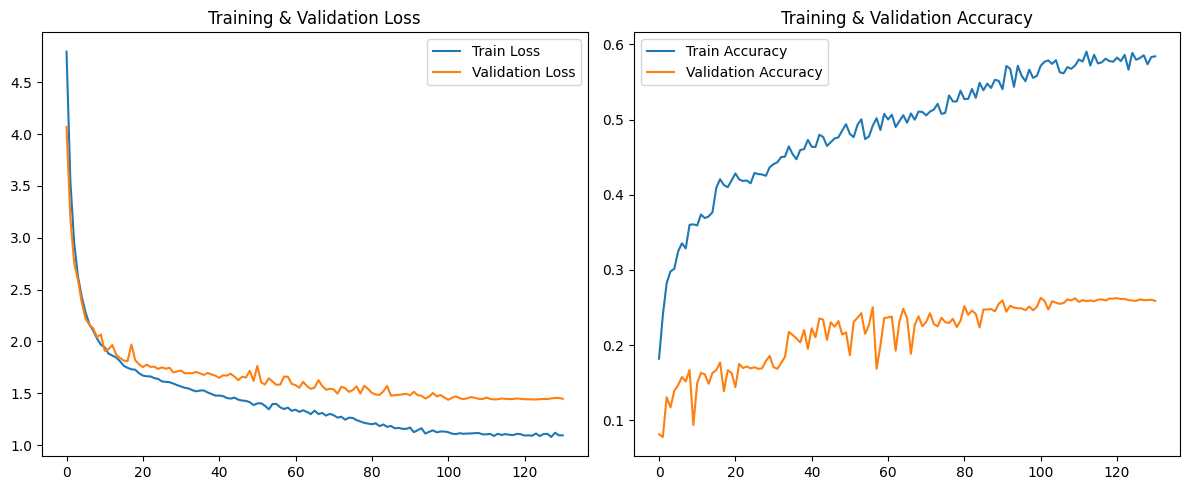

In [9]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

219/219 [==============================] - 99s 450ms/step


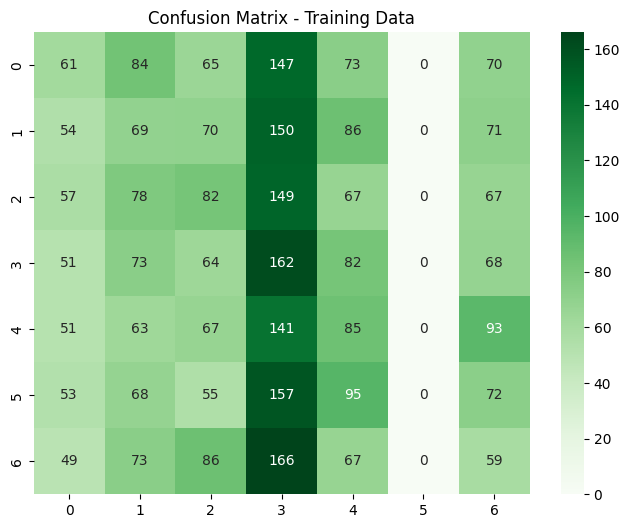

126/126 [==============================] - 34s 269ms/step


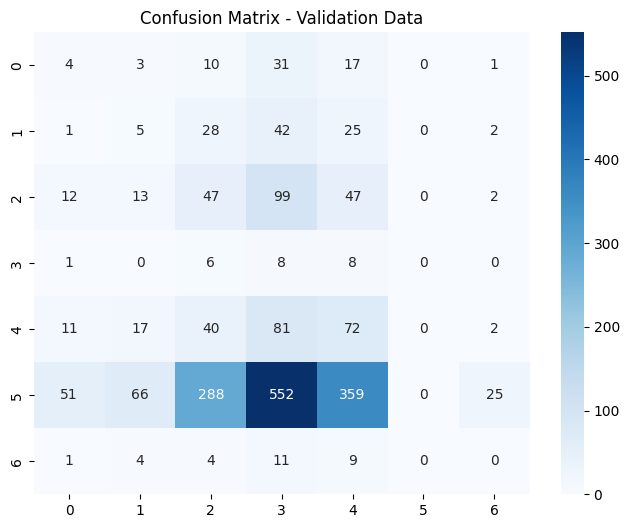

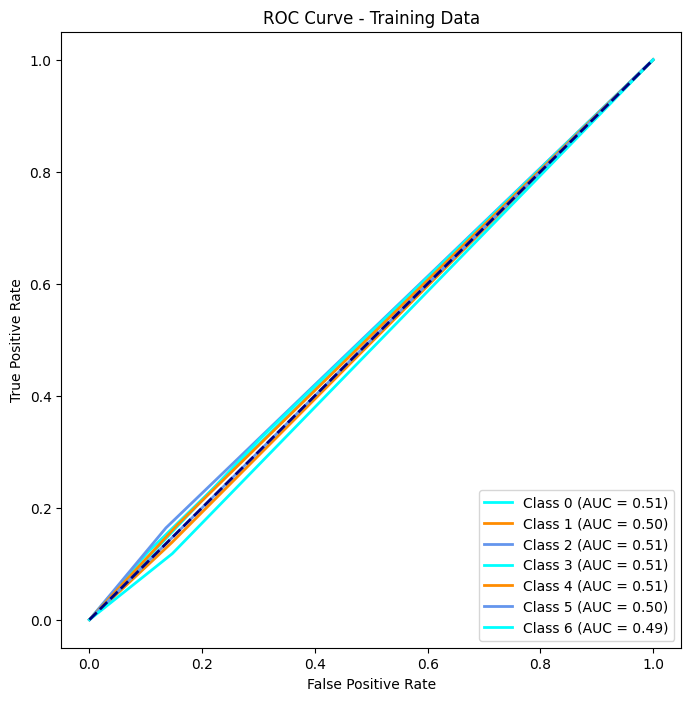

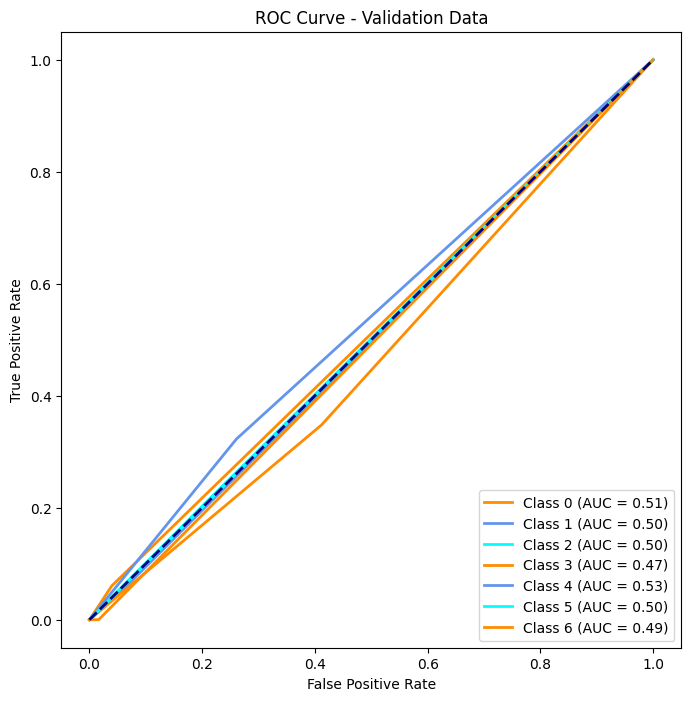

In [10]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
